In [1]:
import pandas as pd
import numpy as np

# Step 1: Define the start time
start_time = pd.Timestamp("2025-02-20 14:30:00+00:00")

# Step 2: Initialize storage for bars
barsDB = {}
# Output file
output_file = "BarsDB/Symbol7_20250423.csv"

# Step 3: Process the CSV file in chunks
chunk_size = 10000
chunks = pd.read_csv("/home/w.belhouene@quant-dev.tn/Téléchargements/parsed_files/data_feeds_20250423_20250423_IEXTP1_TOPS1.6.csv", parse_dates=["Timestamp"], chunksize=chunk_size)

for chunk in chunks:
    quotes = chunk[chunk["Message_Type"] == "QuoteUpdate"].copy()
    trades = chunk[chunk["Message_Type"] == "TradeReport"].copy()

    quotes.dropna(subset=["Bid_Price", "Ask_Price", "Bid_Size", "Ask_Size"], inplace=True)
    trades.dropna(subset=["Price", "Size"], inplace=True)

    quotes = quotes[(quotes["Bid_Price"] != 0) & (quotes["Ask_Price"] != 0)]
    trades = trades[trades["Price"] != 0]

    quotes = quotes[quotes["Timestamp"] >= start_time]
    trades = trades[trades["Timestamp"] >= start_time]

    if quotes.empty and trades.empty:
        continue

    quotes.set_index("Timestamp", inplace=True)
    trades.set_index("Timestamp", inplace=True)

    for symbol in trades["Symbol"].unique():
        symbol_trades = trades[trades["Symbol"] == symbol].copy()
        symbol_quotes = quotes[quotes["Symbol"] == symbol].copy()

        if symbol_trades.empty and symbol_quotes.empty:
            continue

        trades_df = symbol_trades[["Price", "Size"]].copy()
        trades_df["Bid_Price"] = np.nan
        trades_df["Ask_Price"] = np.nan
        trades_df["Bid_Size"] = np.nan
        trades_df["Ask_Size"] = np.nan
        trades_df["Source"] = "Trade"

        quotes_df = symbol_quotes[["Bid_Price", "Ask_Price", "Bid_Size", "Ask_Size"]].copy()
        quotes_df["Price"] = np.nan
        quotes_df["Size"] = quotes_df["Bid_Size"] + quotes_df["Ask_Size"]
        quotes_df["Source"] = "Quote"

        combined_df = pd.concat([trades_df, quotes_df], sort=False)
        combined_df.sort_index(inplace=True)

        end_time = combined_df.index.max()
        if end_time < start_time:
            continue

        time_index = pd.date_range(start=start_time, end=end_time, freq="1min")

        trade_only = combined_df[combined_df["Source"] == "Trade"].copy()
        trade_bars = trade_only.resample("1min").agg({
            "Price": ["first", "last", "max", "min", "mean"],
            "Size": "sum"
        })
        trade_bars.columns = ["open", "close", "high_trade", "low_trade", "average_trade", "volume"]

        combined_bars = combined_df.resample("1min").agg({
            "Bid_Price": "min",
            "Ask_Price": "max",
            "Price": ["max", "min"]
        })
        combined_bars.columns = ["bid_min", "ask_max", "price_max", "price_min"]

        bars = pd.concat([trade_bars, combined_bars], axis=1)
        bars = bars.reindex(time_index)

        bars["high"] = bars[["ask_max", "price_max", "high_trade"]].max(axis=1, skipna=True)
        bars["low"] = bars[["bid_min", "price_min", "low_trade"]].min(axis=1, skipna=True)
        bars["average"] = bars["average_trade"]

        bars.drop(columns=["bid_min", "ask_max", "price_max", "price_min", "high_trade", "low_trade", "average_trade"], inplace=True)
        bars = bars[~((bars["high"] == 0) & (bars["low"] == 0))]
        bars["Symbol"] = symbol
        bars.reset_index(inplace=True)
        bars.rename(columns={"index": "Timestamp"}, inplace=True)

        if symbol in barsDB:
            existing_bars = barsDB[symbol]
            combined_bars = pd.concat([existing_bars, bars], ignore_index=True)
            combined_bars = combined_bars.groupby("Timestamp", as_index=False).agg({
                "open": "first",
                "close": "last",
                "high": "max",
                "low": "min",
                "volume": "sum",
                "average": "mean",
                "Symbol": "first"
            })
            barsDB[symbol] = combined_bars
        else:
            barsDB[symbol] = bars

# Step 11: Final processing and technical indicators
final_bars = []
for symbol, bars in barsDB.items():
    bars = bars.sort_values("Timestamp").copy()
    bars.set_index("Timestamp", inplace=True)
    time_index = pd.date_range(start=start_time, end=bars.index.max(), freq="1min")
    bars = bars.reindex(time_index)

    temp_bars = bars[["close"]].copy()
    temp_bars.ffill(inplace=True)
    temp_bars.fillna(0, inplace=True)

    bars["SMA_5min"] = temp_bars["close"].rolling(window=5, min_periods=1).mean()
    bars["EMA_5min"] = temp_bars["close"].ewm(span=5, adjust=False).mean()

    temp_bars["SMA_20"] = temp_bars["close"].rolling(window=20, min_periods=1).mean()
    temp_bars["stddev_20"] = temp_bars["close"].rolling(window=20, min_periods=1).std()
    bars["BB_middle"] = temp_bars["SMA_20"]
    bars["BB_upper"] = temp_bars["SMA_20"] + 2 * temp_bars["stddev_20"]
    bars["BB_lower"] = temp_bars["SMA_20"] - 2 * temp_bars["stddev_20"]

    ema12 = temp_bars["close"].ewm(span=12, adjust=False).mean()
    ema26 = temp_bars["close"].ewm(span=26, adjust=False).mean()
    bars["MACD"] = ema12 - ema26
    bars["MACD_Signal"] = bars["MACD"].ewm(span=9, adjust=False).mean()
    bars["MACD_Hist"] = bars["MACD"] - bars["MACD_Signal"]

    delta = temp_bars["close"].diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.rolling(window=14, min_periods=1).mean()
    avg_loss = loss.rolling(window=14, min_periods=1).mean()
    rs = avg_gain / (avg_loss + 1e-10)
    bars["RSI_14"] = 100 - (100 / (1 + rs))

    bars = bars[~((bars["high"] == 0) & (bars["low"] == 0))]
    bars["Symbol"] = symbol
    bars.reset_index(inplace=True)
    bars.rename(columns={"index": "Timestamp"}, inplace=True)
    final_bars.append(bars)

# Step 12: Save to CSV
if final_bars:
    combined_bars = pd.concat(final_bars, ignore_index=True)
    combined_bars = combined_bars[[
        "Timestamp", "Symbol", "open", "close", "high", "low", "volume", "average",
        "SMA_5min", "EMA_5min",
        "BB_middle", "BB_upper", "BB_lower",
        "MACD", "MACD_Signal", "MACD_Hist",
        "RSI_14"
    ]]
    combined_bars.to_csv(output_file, index=False)
    print(f"Saved 1-minute bars with technical indicators to: {output_file}")
else:
    print("No data to save.")


Saved 1-minute bars with technical indicators to: BarsDB/Symbol7_20250423.csv


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
df = pd.read_csv("Output_Data/new_barsDBase_AAPL.csv", parse_dates=["Timestamp"])
df.set_index("Timestamp", inplace=True)
symbol = "AAPL"
df = df[df["Symbol"] == symbol]

plt.style.use("seaborn-v0_8-darkgrid")

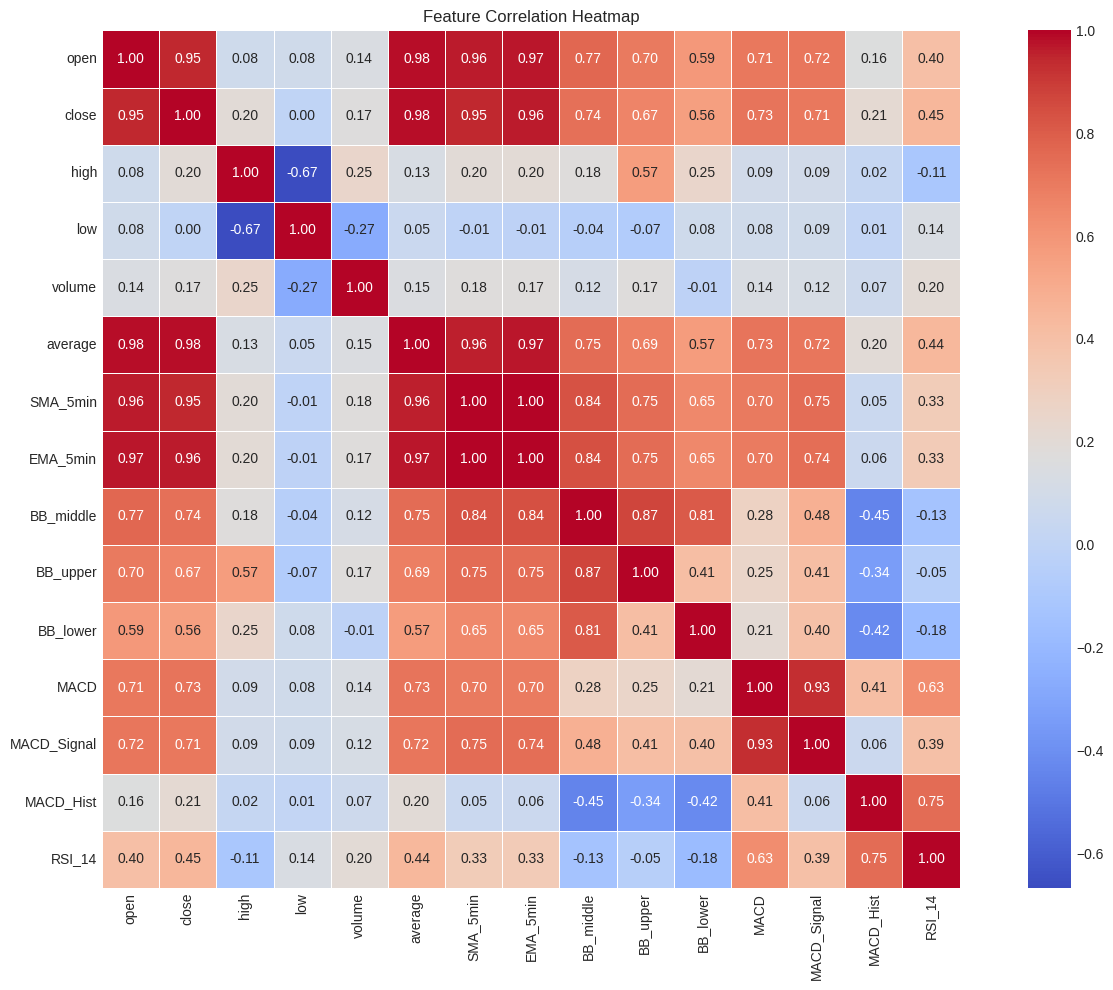


Highly correlated feature pairs:
close ↔ open = 0.95
average ↔ open = 0.98
average ↔ close = 0.98
SMA_5min ↔ open = 0.96
SMA_5min ↔ close = 0.95
SMA_5min ↔ average = 0.96
EMA_5min ↔ open = 0.97
EMA_5min ↔ close = 0.96
EMA_5min ↔ average = 0.97
EMA_5min ↔ SMA_5min = 1.00
BB_upper ↔ BB_middle = 0.87
MACD_Signal ↔ MACD = 0.93


In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the bars file
df = pd.read_csv("Output_Data/new_barsDBase_AAPL.csv", parse_dates=["Timestamp"])

# Drop non-numeric and irrelevant columns
numeric_df = df.drop(columns=["Timestamp", "Symbol"])

# Compute the correlation matrix
corr_matrix = numeric_df.corr()

# Save correlation matrix to CSV (optional)
corr_matrix.to_csv("Output_Data/correlation_matrix.csv")

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, square=True)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.savefig("Output_Data/correlation_heatmap.png")
plt.show()

# Optionally: Print pairs with high correlation (> 0.85)
threshold = 0.85
print("\nHighly correlated feature pairs:")
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            print(f"{corr_matrix.columns[i]} ↔ {corr_matrix.columns[j]} = {corr_matrix.iloc[i, j]:.2f}")


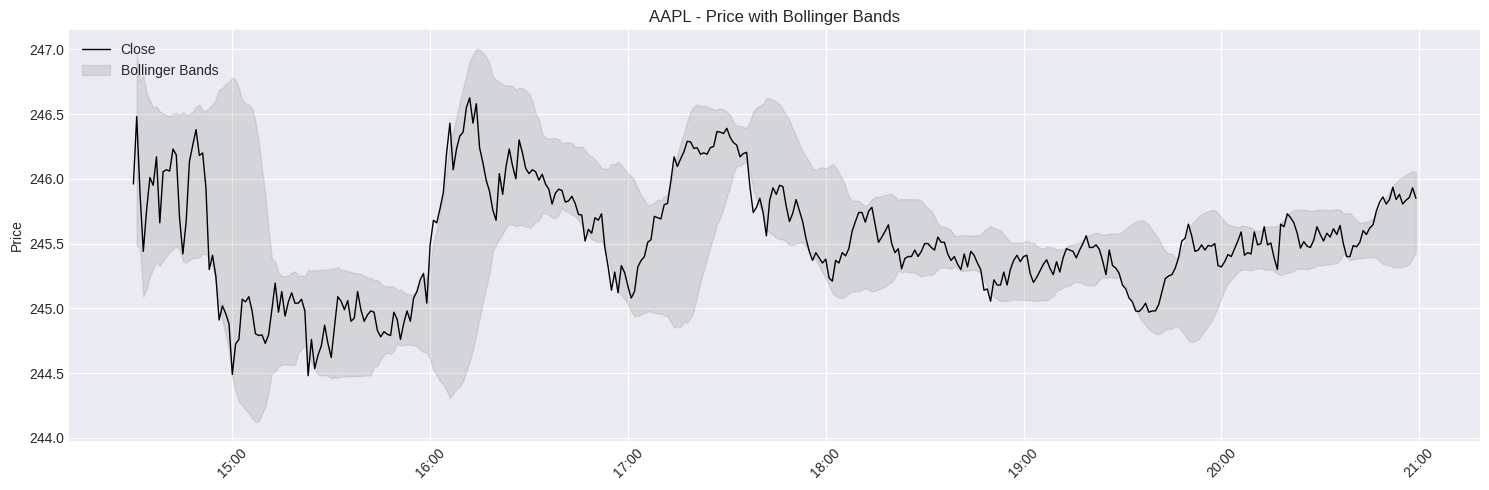

In [4]:
# --- Plot 1: Price + Bollinger Bands ---
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(df.index, df["close"], label="Close", color="black", linewidth=1)
ax1.fill_between(df.index, df["BB_upper"], df["BB_lower"], color='gray', alpha=0.2, label="Bollinger Bands")
ax1.set_title(f"{symbol} - Price with Bollinger Bands")
ax1.set_ylabel("Price")
ax1.legend(loc="upper left")
ax1.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

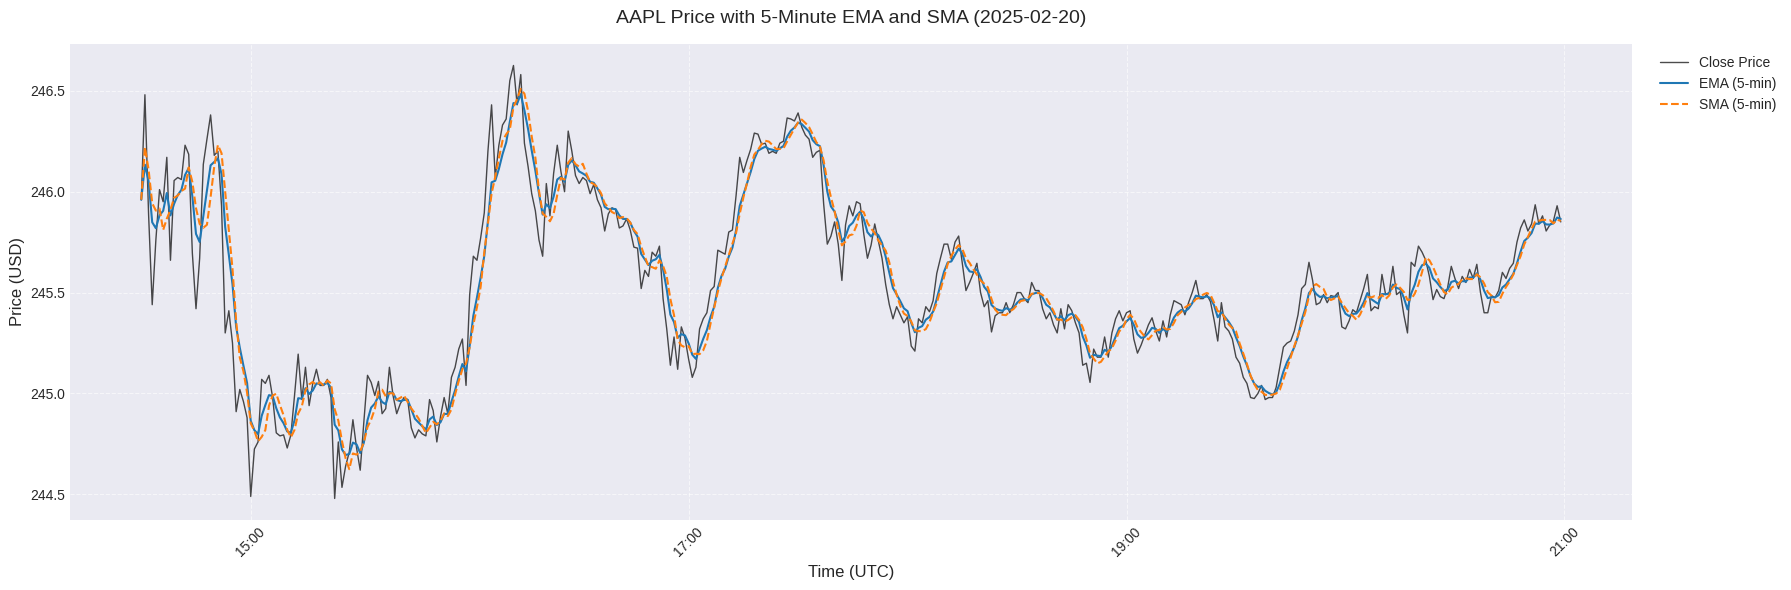

In [15]:
# Plot EMA5 and SMA5
fig, ax1 = plt.subplots(figsize=(18, 6))  # Increase figure size for better readability
ax1.plot(df.index, df["close"], label="Close Price", color="black", linewidth=1, alpha=0.7)
ax1.plot(df.index, df["EMA_5min"], label="EMA (5-min)", color="#1f77b4", linewidth=1.5)  # Blue, solid
ax1.plot(df.index, df["SMA_5min"], label="SMA (5-min)", color="#ff7f0e", linestyle="--", linewidth=1.5)  # Orange, dashed

# Set title and labels with larger font sizes
ax1.set_title("AAPL Price with 5-Minute EMA and SMA (2025-02-20)", fontsize=14, pad=15)
ax1.set_ylabel("Price (USD)", fontsize=12)
ax1.set_xlabel("Time (UTC)", fontsize=12)

# Customize x-axis: Show date and time, with ticks every 2 hours
ax1.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45, fontsize=10)

# Add grid for better readability
ax1.grid(True, linestyle="--", alpha=0.6)

# Customize y-axis ticks
ax1.tick_params(axis="y", labelsize=10)

# Position the legend outside the plot to avoid overlap
ax1.legend(loc="upper left", bbox_to_anchor=(1.01, 1), fontsize=10)

# Tight layout to prevent clipping
plt.tight_layout()

# Show the plot
plt.show()

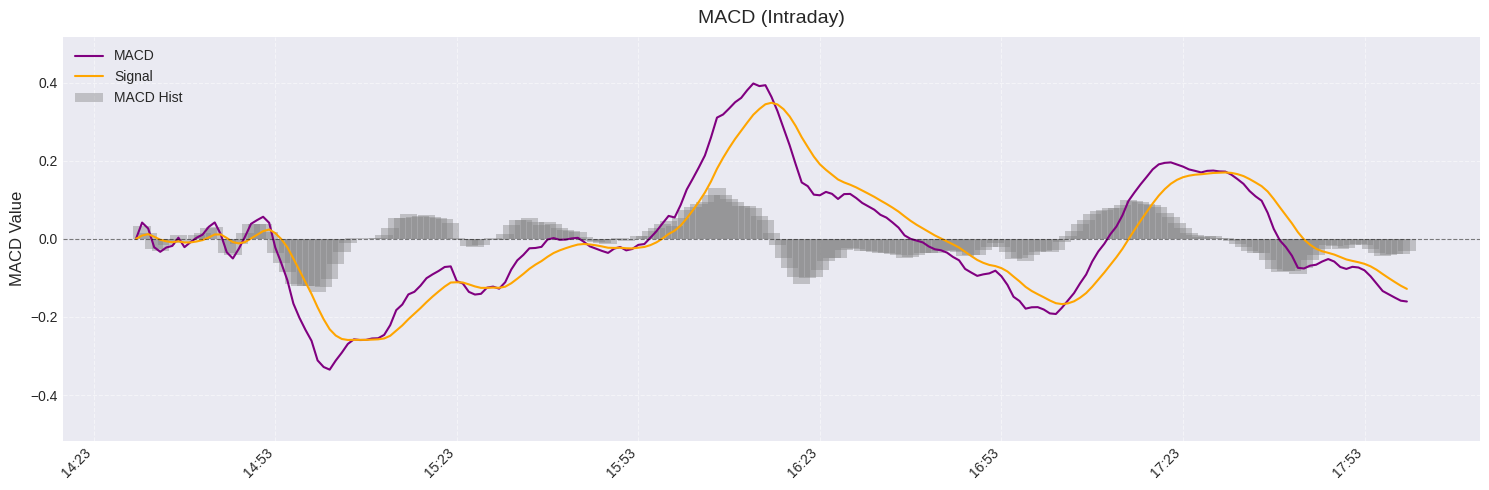

In [5]:

# Assume df is already loaded and filtered for AAPL
# If not, load the data as before
df = pd.read_csv("Output_Data/new_barsDBase_AAPL.csv", parse_dates=["Timestamp"])
df.set_index("Timestamp", inplace=True)

# Filter for the symbol (e.g., AAPL)
symbol = "AAPL"
df = df[df["Symbol"] == symbol]

# --- Plot 2: Improved MACD ---
fig, ax2 = plt.subplots(figsize=(15, 5))

# Limit x-axis to a shorter time range for better readability (e.g., 14:30 to 18:00 UTC)
market_start = pd.to_datetime("2025-02-20 14:30:00+00:00")
market_end = pd.to_datetime("2025-02-20 18:00:00+00:00")
df_intraday = df[(df.index >= market_start) & (df.index <= market_end)]

# Plot MACD and Signal with slightly thicker lines
ax2.plot(df_intraday.index, df_intraday["MACD"], label="MACD", color="purple", linewidth=1.5)
ax2.plot(df_intraday.index, df_intraday["MACD_Signal"], label="Signal", color="orange", linewidth=1.5)

# Plot histogram with reduced transparency and adjusted width
ax2.bar(df_intraday.index, df_intraday["MACD_Hist"], label="MACD Hist", color="grey", alpha=0.4, width=0.002)

# Adjust y-axis limits to accommodate both MACD/Signal lines and histogram
macd_range = max(abs(df_intraday["MACD"].max()), abs(df_intraday["MACD"].min()))
signal_range = max(abs(df_intraday["MACD_Signal"].max()), abs(df_intraday["MACD_Signal"].min()))
hist_range = max(abs(df_intraday["MACD_Hist"].max()), abs(df_intraday["MACD_Hist"].min()))
y_limit = max(macd_range, signal_range, hist_range) * 1.3  # Add 30% padding
ax2.set_ylim(-y_limit, y_limit)

# Add a horizontal line at y=0 for reference
ax2.axhline(0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)

# Customize the plot
ax2.set_title("MACD (Intraday)", fontsize=14, pad=10)
ax2.set_ylabel("MACD Value", fontsize=12)
ax2.legend(loc="upper left", fontsize=10)

# Adjust x-axis ticks
ax2.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))  # Major ticks every 30 minutes
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax2.xaxis.set_minor_locator(mdates.MinuteLocator(interval=10))  # Minor ticks every 10 minutes

# Rotate and align x-axis labels
plt.xticks(rotation=45, ha="right", fontsize=10)

# Add a less intrusive grid
ax2.grid(True, linestyle="--", alpha=0.5)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


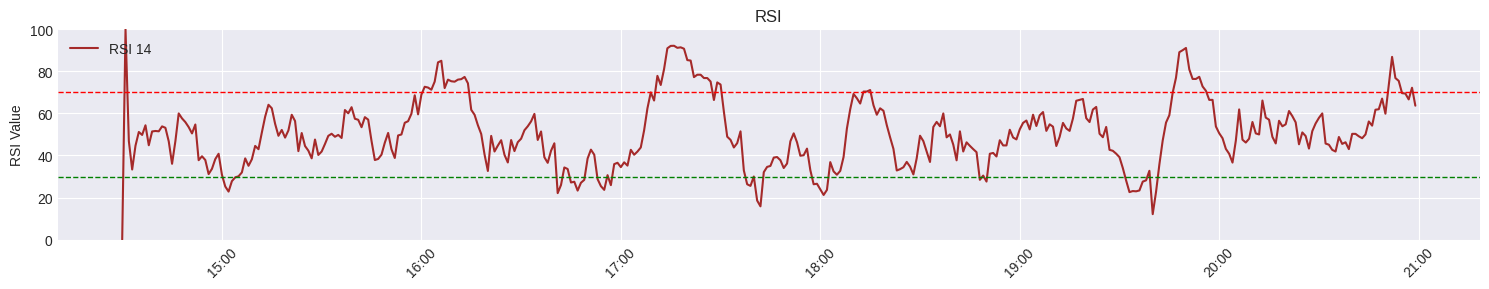

In [6]:
# --- Plot 3: RSI ---
fig, ax3 = plt.subplots(figsize=(15, 3))
ax3.plot(df.index, df["RSI_14"], label="RSI 14", color="brown")
ax3.axhline(70, color='red', linestyle='--', linewidth=1)
ax3.axhline(30, color='green', linestyle='--', linewidth=1)
ax3.set_ylim(0, 100)
ax3.set_title("RSI")
ax3.set_ylabel("RSI Value")
ax3.legend(loc="upper left")
ax3.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

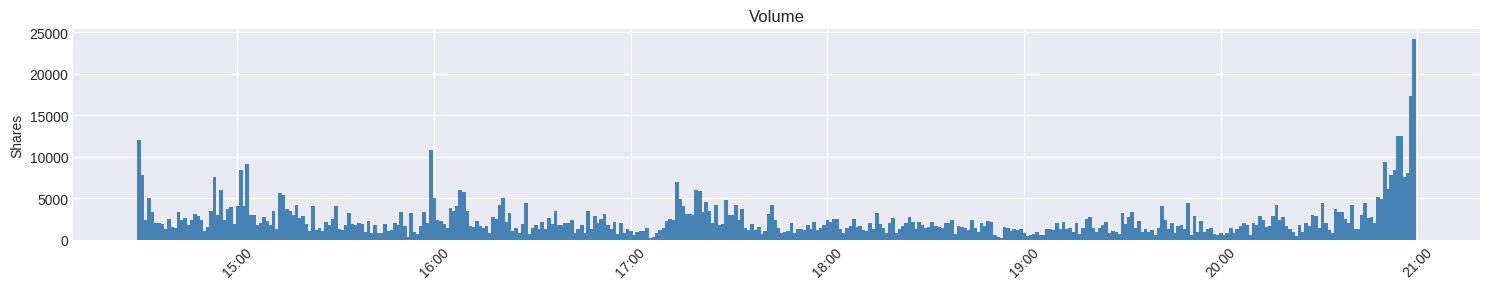

In [7]:
# --- Plot 4: Volume ---
fig, ax4 = plt.subplots(figsize=(15, 3))
ax4.bar(df.index, df["volume"], width=0.0008, color="steelblue")
ax4.set_title("Volume")
ax4.set_ylabel("Shares")
ax4.set_yscale("linear")  # Change to 'log' if volume values vary too much
ax4.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
import pandas as pd
import glob

# List all BarsDB CSV files
bars_files = glob.glob("BarsDB/*.csv")  # Adjust the folder name if needed

# Read and merge all CSV files
dfs = [pd.read_csv(file, parse_dates=["Timestamp"]) for file in bars_files]
df_merged = pd.concat(dfs, ignore_index=True)

# Sort by Symbol and Timestamp
df_merged = df_merged.sort_values(["Symbol", "Timestamp"])

# Drop duplicate rows if any (based on all columns)
df_merged = df_merged.drop_duplicates()

# Save the final cleaned and merged dataset
df_merged.to_csv("merged_barsDBase.csv", index=False)


In [2]:
import pandas as pd
import numpy as np

# Step 1: Define the start time
start_time = pd.Timestamp("2025-02-20 14:30:00+00:00")

# Step 2: Initialize storage for bars
barsDB = {}
# Output file
output_file = "BarsDB/Symbol7_20250424.csv"

# Step 3: Process the CSV file in chunks
chunk_size = 10000
chunks = pd.read_csv("/home/w.belhouene@quant-dev.tn/Téléchargements/parsed_files/data_feeds_20250424_20250424_IEXTP1_TOPS1.6.csv", parse_dates=["Timestamp"], chunksize=chunk_size)

for chunk in chunks:
    quotes = chunk[chunk["Message_Type"] == "QuoteUpdate"].copy()
    trades = chunk[chunk["Message_Type"] == "TradeReport"].copy()

    quotes.dropna(subset=["Bid_Price", "Ask_Price", "Bid_Size", "Ask_Size"], inplace=True)
    trades.dropna(subset=["Price", "Size"], inplace=True)

    quotes = quotes[(quotes["Bid_Price"] != 0) & (quotes["Ask_Price"] != 0)]
    trades = trades[trades["Price"] != 0]

    quotes = quotes[quotes["Timestamp"] >= start_time]
    trades = trades[trades["Timestamp"] >= start_time]

    if quotes.empty and trades.empty:
        continue

    quotes.set_index("Timestamp", inplace=True)
    trades.set_index("Timestamp", inplace=True)

    for symbol in trades["Symbol"].unique():
        symbol_trades = trades[trades["Symbol"] == symbol].copy()
        symbol_quotes = quotes[quotes["Symbol"] == symbol].copy()

        if symbol_trades.empty and symbol_quotes.empty:
            continue

        trades_df = symbol_trades[["Price", "Size"]].copy()
        trades_df["Bid_Price"] = np.nan
        trades_df["Ask_Price"] = np.nan
        trades_df["Bid_Size"] = np.nan
        trades_df["Ask_Size"] = np.nan
        trades_df["Source"] = "Trade"

        quotes_df = symbol_quotes[["Bid_Price", "Ask_Price", "Bid_Size", "Ask_Size"]].copy()
        quotes_df["Price"] = np.nan
        quotes_df["Size"] = quotes_df["Bid_Size"] + quotes_df["Ask_Size"]
        quotes_df["Source"] = "Quote"

        combined_df = pd.concat([trades_df, quotes_df], sort=False)
        combined_df.sort_index(inplace=True)

        end_time = combined_df.index.max()
        if end_time < start_time:
            continue

        time_index = pd.date_range(start=start_time, end=end_time, freq="1min")

        trade_only = combined_df[combined_df["Source"] == "Trade"].copy()
        trade_bars = trade_only.resample("1min").agg({
            "Price": ["first", "last", "max", "min", "mean"],
            "Size": "sum"
        })
        trade_bars.columns = ["open", "close", "high_trade", "low_trade", "average_trade", "volume"]

        combined_bars = combined_df.resample("1min").agg({
            "Bid_Price": "min",
            "Ask_Price": "max",
            "Price": ["max", "min"]
        })
        combined_bars.columns = ["bid_min", "ask_max", "price_max", "price_min"]

        bars = pd.concat([trade_bars, combined_bars], axis=1)
        bars = bars.reindex(time_index)

        bars["high"] = bars[["ask_max", "price_max", "high_trade"]].max(axis=1, skipna=True)
        bars["low"] = bars[["bid_min", "price_min", "low_trade"]].min(axis=1, skipna=True)
        bars["average"] = bars["average_trade"]

        bars.drop(columns=["bid_min", "ask_max", "price_max", "price_min", "high_trade", "low_trade", "average_trade"], inplace=True)
        bars = bars[~((bars["high"] == 0) & (bars["low"] == 0))]
        bars["Symbol"] = symbol
        bars.reset_index(inplace=True)
        bars.rename(columns={"index": "Timestamp"}, inplace=True)

        if symbol in barsDB:
            existing_bars = barsDB[symbol]
            combined_bars = pd.concat([existing_bars, bars], ignore_index=True)
            combined_bars = combined_bars.groupby("Timestamp", as_index=False).agg({
                "open": "first",
                "close": "last",
                "high": "max",
                "low": "min",
                "volume": "sum",
                "average": "mean",
                "Symbol": "first"
            })
            barsDB[symbol] = combined_bars
        else:
            barsDB[symbol] = bars

# Step 11: Final processing and technical indicators
final_bars = []
for symbol, bars in barsDB.items():
    bars = bars.sort_values("Timestamp").copy()
    bars.set_index("Timestamp", inplace=True)
    time_index = pd.date_range(start=start_time, end=bars.index.max(), freq="1min")
    bars = bars.reindex(time_index)

    temp_bars = bars[["close"]].copy()
    temp_bars.ffill(inplace=True)
    temp_bars.fillna(0, inplace=True)

    bars["SMA_5min"] = temp_bars["close"].rolling(window=5, min_periods=1).mean()
    bars["EMA_5min"] = temp_bars["close"].ewm(span=5, adjust=False).mean()

    temp_bars["SMA_20"] = temp_bars["close"].rolling(window=20, min_periods=1).mean()
    temp_bars["stddev_20"] = temp_bars["close"].rolling(window=20, min_periods=1).std()
    bars["BB_middle"] = temp_bars["SMA_20"]
    bars["BB_upper"] = temp_bars["SMA_20"] + 2 * temp_bars["stddev_20"]
    bars["BB_lower"] = temp_bars["SMA_20"] - 2 * temp_bars["stddev_20"]

    ema12 = temp_bars["close"].ewm(span=12, adjust=False).mean()
    ema26 = temp_bars["close"].ewm(span=26, adjust=False).mean()
    bars["MACD"] = ema12 - ema26
    bars["MACD_Signal"] = bars["MACD"].ewm(span=9, adjust=False).mean()
    bars["MACD_Hist"] = bars["MACD"] - bars["MACD_Signal"]

    delta = temp_bars["close"].diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.rolling(window=14, min_periods=1).mean()
    avg_loss = loss.rolling(window=14, min_periods=1).mean()
    rs = avg_gain / (avg_loss + 1e-10)
    bars["RSI_14"] = 100 - (100 / (1 + rs))

    bars = bars[~((bars["high"] == 0) & (bars["low"] == 0))]
    bars["Symbol"] = symbol
    bars.reset_index(inplace=True)
    bars.rename(columns={"index": "Timestamp"}, inplace=True)
    final_bars.append(bars)

# Step 12: Save to CSV
if final_bars:
    combined_bars = pd.concat(final_bars, ignore_index=True)
    combined_bars = combined_bars[[
        "Timestamp", "Symbol", "open", "close", "high", "low", "volume", "average",
        "SMA_5min", "EMA_5min",
        "BB_middle", "BB_upper", "BB_lower",
        "MACD", "MACD_Signal", "MACD_Hist",
        "RSI_14"
    ]]
    combined_bars.to_csv(output_file, index=False)
    print(f"Saved 1-minute bars with technical indicators to: {output_file}")
else:
    print("No data to save.")


Saved 1-minute bars with technical indicators to: BarsDB/Symbol7_20250424.csv
